# Coal production in mines 2013

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set();

## Cleaned data

We claned this data in the notebook stored in : deliver/Data_cleaning.ipynb

In [2]:
df = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col="MSHA ID")
df[['Year','Mine_Name']].head()

,Year,Mine_Name
MSHA ID,,
103381,2013,Tacoa Highwall Miner
103404,2013,Reid School Mine
100759,2013,North River #1 Underground Min
103246,2013,Bear Creek
103451,2013,Knight Mine


# Predict the Production of coal mines

In [3]:
features = [
'Average_Employees',
'Labor_Hours'
           ]

categoricals=[
            'Mine_State',
            'Mine_County',
            'Mine_Status',
            'Mine_Type',
            'Company_Type',
            'Operation_Type',
            'Union_Code',
            'Coal_Supply_Region' #command +[ to move]
]

target = 'log_production'

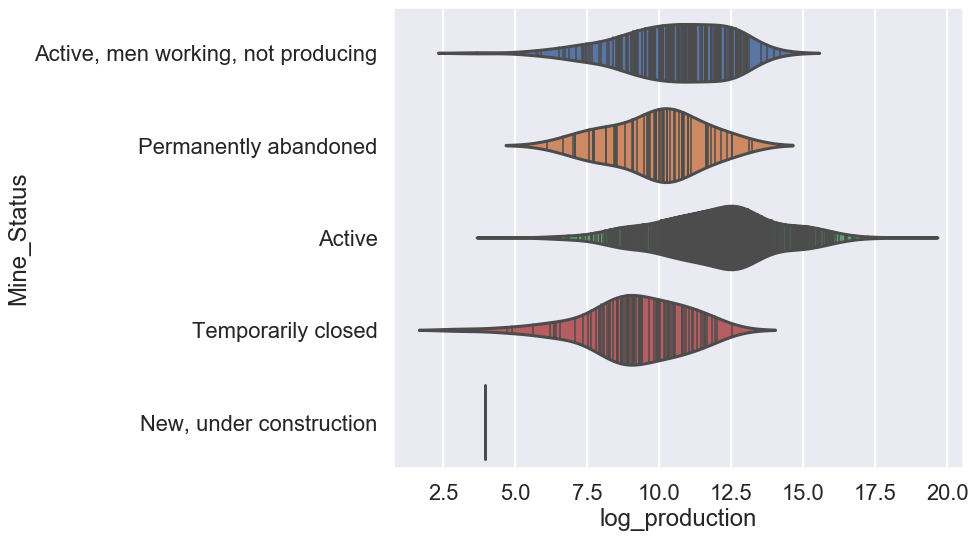

In [4]:
sns.set_context('poster')
fig = plt.subplots(figsize=(14,8))

sns.violinplot(y='Mine_Status', x='log_production', data=df, split=True,
              inner='stick',)
plt.tight_layout()
plt.savefig("../figures/Coal_prediction_company_type_vs_log_production.png")

In [5]:
pd.get_dummies(df['Company_Type']).sample(50).head()

,Contractor,Independent Producer Operator,Operating Subsidiary
MSHA ID,,,
3609702,0,1,0
103423,0,1,0
3601262,0,1,0
3608273,0,1,0
3605023,0,1,0


In [6]:
dummy_categoricals= []
for categorical in categoricals:
   # Avoid the dummy variable trap!
    drop_var=sorted(df[categorical].unique())[-1]
    temp_df=pd.get_dummies(df[categorical],prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals +=temp_df.columns.tolist()

# Random Forest Regressor

In [7]:
train, test=train_test_split(df, test_size=0.3)

In [8]:
rf=RandomForestRegressor(n_estimators=100,oob_score=True)
rf.fit(train[features+dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

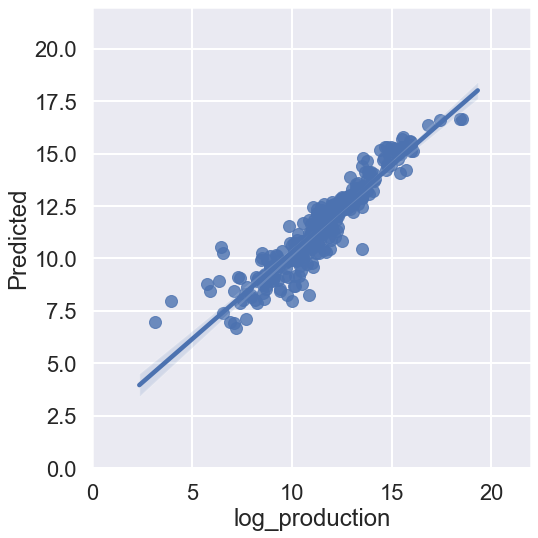

In [9]:
sns.set_context('poster')
fig=plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features+dummy_categoricals]))
plt.xlim(0,22)
plt.ylim(0,22)
plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig("../figures/Coal-production-RF-prediction.png")

In [10]:
predicted=rf.predict(test[features+dummy_categoricals])
print ("R^2 score:", r2_score(test[target], predicted))
print ("MSE:", mean_squared_error(test[target], predicted))

R^2 score: 0.8690167382207539
MSE: 0.7096566259094641


In [11]:
rf_importances=pd.DataFrame({'name': train[features + dummy_categoricals].columns,
                             'importance':rf.feature_importances_
                            }).sort_values(by='importance', ascending=False).reset_index(drop=True)

rf_importances.head(5)

,name,importance
0,Labor_Hours,0.848043
1,Average_Employees,0.051716
2,Mine_Type_Surface,0.008927
3,Coal_Supply_Region_Powder River Basin,0.007965
4,Mine_Status_Active,0.005717


# Conclusion